In [66]:
!pip install simpy

In [67]:
import numpy as np
import simpy as sp
import statistics as st
import matplotlib.pyplot as plt
import prettytable as pt

#Индивидуальное задание (Вариант 15)

Рассматривается простейшая двухканальная СМО с «не терпеливыми» заявками. 

Интенсивность потока заявок $ \lambda $ = 3 заявки/ч; 

среднее время обслуживания одной заявки $ t_{s} = 1 /\mu $ = 1 ч; 

средний срок, в течение которого заявка «терпеливо» стоит в очереди, равен 0,5 ч. 

Подсчитать финальные вероятности состояний, ограничиваясь теми, которые не меньше 0,001. 

Найти характеристики эффективности СМО: абсолютную и относительную пропускные способности системы, среднее время пребывания заявки в системе, среднюю длину очереди.

Финальные вероятности

$ \rho = \lambda / \mu $

$ \beta = v / \mu $

$ p_{0} = (1 + \frac{\rho}{1!} + \frac{\rho^2}{2!} + ...+ \frac{\rho^n}{n!} + \frac{\rho^n}{n!} * \sum_{i = 1}^\infty \frac{\rho^i}{\prod_{l = 1}^i (n + l\beta)})^{-1} $

Ошибка, возникающая от отбрасывания всех членов
бесконечной суммы, начиная с $ r $-го, меньше, чем $ \frac{\rho^n}{n!} * \frac{(\rho / \beta)^n}{r!} * e^{-\rho/ \beta} $ 

$ p_{k} = \frac{\rho^k}{k!} * p_{0}, (k = \bar{1, n}) $ 

$ p_{n + i} = p_{n} * \frac{\rho^i}{\prod_{l = 1}^i (n + l\beta)}, (i = \bar{1, r-n}) $ 

In [68]:
def get_theoretical_final_probabilities(n, rho, beta, r):
  p_0 = (np.sum([(rho ** i) / np.math.factorial(i) for i in range(n + 1)]) + ((rho ** n) / np.math.factorial(n)) * (np.sum([(rho ** i) / (np.prod([n + l * beta for l in range(1, i + 1)])) for i in range(1, r + 1)]))) ** -1
  final_probabilities = [p_0] + [((rho ** k) / np.math.factorial(k)) * p_0 for k in range(1, n + 1)]
  p_n = final_probabilities[-1]
  final_probabilities += [((rho ** i) / (np.prod([n + l * beta for l in range(1, i + 1)]))) * p_n for i in range(n - 1, r - n + 1 )]
  return final_probabilities

In [69]:
def find_r(n, rho, beta, alpha):
  r = 0
  while ((rho ** n) / np.math.factorial(n)) * (((rho / beta) ** r) / np.math.factorial(r)) * np.exp(-rho / beta) >= alpha:
    r +=1
  return r

Вероятность образования очереди

$ p_{q} = \sum_{i = 0}^{r - n -1} p_{n + i} $

In [70]:
def get_theoretical_queue_probability(n, r, final_probabilities):
  return np.sum([final_probabilities[n + i] for i in range(0, r - n)])

Вероятность отказа

$ p_{r} = 1 - \sum_{i = 0}^{r} p_{i} $

In [71]:
def get_theoretical_reject_probability(final_probabilities):
  return 1 - np.sum(final_probabilities)

Среднее число активных каналов

Среднее число активных каналов можно подсчитать как математическое ожидание случайной величины K (число занятых каналов) с
возможными значениями $ 1, 2, ..., n $ и соответствующими вероятностями $ p_{0}, p_{1}, ...,p_{n -1}, [1 - (p_{0}, p_{1}, ...,p_{n -1})] $ 

$ k = \sum_{i = 0}^{n - 1 } i * p_{i} + n *( 1 - \sum_{i = 1}^{n -1} p_{i}) $

In [72]:
def get_theoretical_average_active_channal_count(final_probabilities, n):
  return np.sum([(i * final_probabilities[i]) for i in range(0, n)]) + n * (1 - np.sum(final_probabilities[:n]))

Абсолютная пропускная способность

$ A = k * \mu $

In [73]:
def get_theoretical_absolute_bandwidth(average_active_channal_count, mu):
  return mu * average_active_channal_count

Относитальная пропускная способность

$ Q = A / \lambda $

In [74]:
def get_theoretical_relative_bandwidth(absolute_bandwidth, _lambda):
  return absolute_bandwidth / _lambda

Среднее число элементов в очереди

$ L_{q} = (\rho - k) / \beta $

In [75]:
def get_theoretical_average_queue_items_count(rho, average_active_channal_count, beta):
  return (rho - average_active_channal_count) / beta

Среднее число элементов в СМО

$ L_{qs} = L_{q} + \bar{k} $

In [76]:
def get_theoretical_average_queue_system_items_count(average_queue_items_count, average_active_channal_count):
  return average_queue_items_count + average_active_channal_count

Среднее время пребывания элемента в очереди

$ T_{q} = L_{q} / \lambda $

In [77]:
def get_theoretical_average_queue_items_time(reject_probability, _lambda):
  return reject_probability / _lambda

Среднее время пребывания элемента в СМО

$ T_{qs} = L_{qs} / \lambda $

In [78]:
def get_theoretical_average_queue_system_items_time(average_queue_system_items_count, _lambda):
  return average_queue_system_items_count / _lambda

In [79]:
def get_theoretical_info(n, _lambda, mu, v, alpha, _round):
  rho = _lambda / mu
  beta = v / mu
  r = find_r(n, rho, beta, alpha)
  final_probabilities = get_theoretical_final_probabilities(n, rho, beta, r)
  queue_probability = np.around(get_theoretical_queue_probability(n, r, final_probabilities), _round)
  reject_probability = np.around(get_theoretical_reject_probability(final_probabilities), _round)
  average_active_channal_count = np.around(get_theoretical_average_active_channal_count(final_probabilities, n), _round) 
  absolute_bandwidth = np.around(get_theoretical_absolute_bandwidth(average_active_channal_count, mu), _round)
  relative_bandwidth = np.around(get_theoretical_relative_bandwidth(absolute_bandwidth, _lambda), _round)
  average_queue_items_count = np.around(get_theoretical_average_queue_items_count(rho, average_active_channal_count, beta), _round)
  average_queue_system_items_count = np.around(get_theoretical_average_queue_system_items_count(average_queue_items_count, average_active_channal_count), _round)
  average_queue_items_time = np.around(get_theoretical_average_queue_items_time(average_queue_items_count, _lambda), _round)
  average_queue_system_items_time = np.around(get_theoretical_average_queue_system_items_time(average_queue_system_items_count, _lambda), _round)
  return np.around(final_probabilities, _round), queue_probability, reject_probability, relative_bandwidth, absolute_bandwidth, average_queue_items_count, average_queue_system_items_count, average_active_channal_count, average_queue_items_time, average_queue_system_items_time

In [80]:
class QueueSystem(object):
  def __init__(self, env, n, _lambda, mu, v): 
    self.n = n
    self._lambda = _lambda
    self.mu = mu
    self.v = v

    self.counts = []
    self.times = []
    self.queue_counts = []
    self.queue_times = []
    
    self.serve_items = []
    self.reject_items = []
    
    self.env = env
    self.resources = sp.Resource(env, n)

  def serve(self):
    yield self.env.timeout(np.random.exponential(1.0 / self.mu))

  def wait(self):
    yield self.env.timeout(np.random.exponential(1.0 / self.v))

  def get_workload(self):
    return self.resources.count
  
  def get_queue_len(self):
    return len(self.resources.queue)

  def start(self, action):
    while True:
      yield self.env.timeout(np.random.exponential(1 / self._lambda))
      self.env.process(action(self))

Финальные вероятности

In [81]:
def get_experimental_final_probabilities(queue_system: QueueSystem, alpha, _round):
  items = np.array(queue_system.reject_items + queue_system.serve_items)
  final_probabilities = []
  r = 1
  while True:
    probability  = (len(items[items == r]) / len(items))
    if np.around(probability, _round) >= alpha:
      final_probabilities.append(probability)
      r += 1
    else: 
      break
  return final_probabilities, r

Вероятность образования очереди

In [82]:
def get_experimental_queue_probability(final_probabilities, n, r):
  return np.sum(final_probabilities[n:r])

Вероятность отказа

In [83]:
def get_experimental_reject_probability(queue_system: QueueSystem, r):
  items = np.array(queue_system.reject_items + queue_system.serve_items)
  return (len(items[items == r]) / len(items))

Среднее число активных каналов

In [84]:
def get_experimental_average_active_channal_count(final_probabilities, n):
  return np.sum([(i * final_probabilities[i]) for i in range(0, n)]) + n * (1 - np.sum(final_probabilities[:n]))

Абсолютная пропускная способность

In [85]:
def get_experimental_absolute_bandwidth(average_active_channal_count, mu):
  return average_active_channal_count * mu

Относитальная пропускная способность

In [86]:
def get_experimental_relative_bandwidth(absolute_bandwidth, _lambda):
  return absolute_bandwidth / _lambda

Среднее число элементов в очереди

In [87]:
def get_experimental_average_queue_items_count(queue_system: QueueSystem):
  return st.mean(queue_system.queue_counts)

Среднее число элементов в СМО

In [88]:
def get_experimental_average_queue_system_items_count(queue_system: QueueSystem):
  return st.mean(queue_system.counts)

Среднее время пребывания элемента в очереди

In [89]:
def get_experimental_average_queue_items_time(queue_system: QueueSystem):
  return st.mean(queue_system.queue_times)

Среднее время пребывания элемента в СМО

In [90]:
def get_experimental_average_queue_system_items_time(queue_system: QueueSystem):
  return st.mean(queue_system.times)

In [91]:
def get_experimental_info(queue_system: QueueSystem, alpha, _round):
  final_probabilities, r = get_experimental_final_probabilities(queue_system, alpha, _round)
  queue_probability = get_experimental_queue_probability(final_probabilities, queue_system.n, r)
  reject_probability = get_experimental_reject_probability(queue_system, r)
  average_active_channal_count = get_experimental_average_active_channal_count(final_probabilities, queue_system.n) 
  absolute_bandwidth = get_experimental_absolute_bandwidth(average_active_channal_count, queue_system.mu)
  relative_bandwidth = get_experimental_relative_bandwidth(absolute_bandwidth, queue_system._lambda)
  average_queue_items_count = get_experimental_average_queue_items_count(queue_system) 
  average_queue_system_items_count = get_experimental_average_queue_system_items_count(queue_system) 
  average_queue_items_time = get_experimental_average_queue_items_time(queue_system) 
  average_queue_system_items_time = get_experimental_average_queue_system_items_time(queue_system)
  return final_probabilities, queue_probability, reject_probability, relative_bandwidth, absolute_bandwidth, average_queue_items_count, average_queue_system_items_count, average_active_channal_count, average_queue_items_time, average_queue_system_items_time

In [92]:
def serve(queue_system: QueueSystem):
  queue_len = queue_system.get_queue_len()
  qn_count = queue_system.get_workload()
  with queue_system.resources.request() as request:
    queue_current_len = queue_system.get_queue_len()
    qn_current_count = queue_system.get_workload()
    queue_system.queue_counts.append(queue_len)
    queue_system.counts.append(queue_len + qn_count)
    start = queue_system.env.now
    response = yield request | queue_system.env.process(queue_system.wait())
    queue_system.queue_times.append(queue_system.env.now - start)
    if request in response:
      yield queue_system.env.process(queue_system.serve())
      queue_system.serve_items.append(queue_current_len + qn_current_count)
    else:
      queue_system.reject_items.append(queue_current_len + qn_current_count)
    queue_system.times.append(queue_system.env.now - start)

In [93]:
def test_case(n, _lambda, mu, v, time, alpha, _round):
  env = sp.Environment()
  queue_system = QueueSystem(env, n, _lambda, mu, v)
  env.process(queue_system.start(serve))
  env.run(until = time)
  
  theoretical_info = (get_theoretical_info(n, _lambda, mu, v, alpha, _round))
  experimental_info = (get_experimental_info(queue_system, alpha, _round))
  
  final_probabilities_len = min(len(theoretical_info[0]), len(experimental_info[0]))
  theoretical_final_probabilities = [theoretical_info[0][i] for i in range(0, final_probabilities_len)]
  experimental_final_probabilities = np.around([experimental_info[0][i] for i in range(0, final_probabilities_len)], _round)
  
  final_probabilities_info = pt.PrettyTable()
  final_probabilities_info.add_column("Теоретические финальные вероятности", theoretical_final_probabilities)
  final_probabilities_info.add_column("Эмпирические финальные вероятности", experimental_final_probabilities)
  print(final_probabilities_info)
  
  plot_histograms(theoretical_final_probabilities, experimental_final_probabilities)

  field_names = ["Вероятность образования очереди", 
                 "Вероятность отказа", 
                 "Относитальная пропускная способность", 
                 "Абсолютная пропускная способность", 
                 "Среднее число элементов в очереди",
                 "Среднее число элементов в СМО",
                 "Среднее число активных каналов",
                 "Среднее время пребывания элемента в очереди",
                 "Среднее время пребывания элемента в СМО"]
  
  for index, value in enumerate(field_names):
    info = pt.PrettyTable()
    info.field_names = ["Исследование", value]
    info.add_row(["Теоретическое", np.around(theoretical_info[index + 1], _round)])
    info.add_row(["Эмпирическое", np.around(experimental_info[index + 1], _round)])
    print(info)


In [94]:
def plot_histograms(theoretical_probabilities, experimental_probabilities):
    plt.style.use('default')
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(25, 5))
    
    ax1.set_title('Теоретические финальные вероятности')
    ax1.bar(range(len(theoretical_probabilities)), theoretical_probabilities, width = 0.2)
    
    ax2.set_title('Эмпирические финальные вероятности')
    ax2.bar(range(len(experimental_probabilities)), experimental_probabilities, width = 0.2)

    ax3.set_title('Финальные вероятности')
    ax3.bar(range(len(theoretical_probabilities)), theoretical_probabilities - experimental_probabilities, width = 0.3)
    ax3.axhline(y = 0, xmin = 0, xmax = len(theoretical_probabilities), color='red')
    
    plt.show()

+-------------------------------------+------------------------------------+
| Теоретические финальные вероятности | Эмпирические финальные вероятности |
+-------------------------------------+------------------------------------+
|                0.069                |               0.068                |
|                0.208                |               0.207                |
|                0.312                |               0.319                |
|                0.234                |               0.235                |
|                0.117                |               0.114                |
|                0.044                |                0.04                |
|                0.013                |               0.012                |
|                0.003                |               0.004                |
|                0.001                |               0.001                |
+-------------------------------------+------------------------------------+

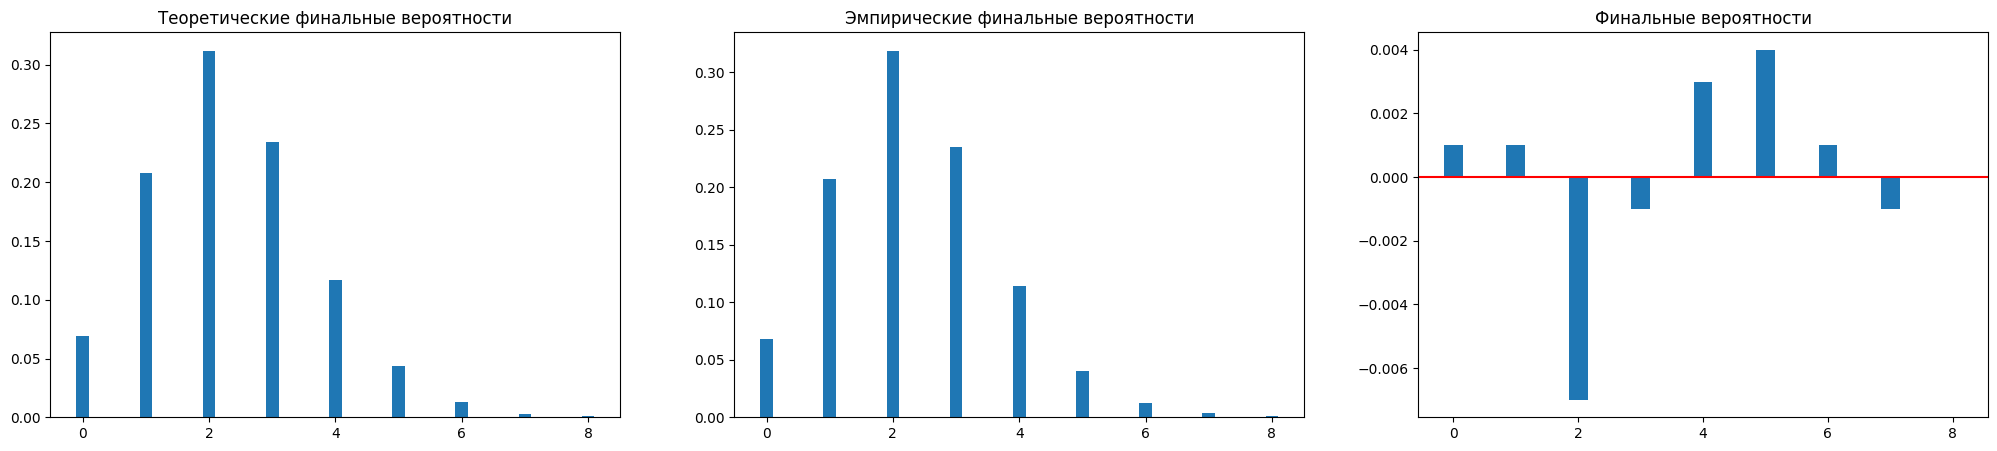

+---------------+---------------------------------+
|  Исследование | Вероятность образования очереди |
+---------------+---------------------------------+
| Теоретическое |              0.722              |
|  Эмпирическое |              0.725              |
+---------------+---------------------------------+
+---------------+--------------------+
|  Исследование | Вероятность отказа |
+---------------+--------------------+
| Теоретическое |        0.0         |
|  Эмпирическое |        0.0         |
+---------------+--------------------+
+---------------+--------------------------------------+
|  Исследование | Относитальная пропускная способность |
+---------------+--------------------------------------+
| Теоретическое |                0.551                 |
|  Эмпирическое |                0.552                 |
+---------------+--------------------------------------+
+---------------+-----------------------------------+
|  Исследование | Абсолютная пропускная способность |
+---

In [97]:
test_case(2, 3, 1, 2, 6000, 0.001, 3)